In [1]:
%reset

In [35]:
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Load and split data

In [27]:
DATA_PATH = "../train/"
dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform)
idx_to_class = tuple([k for k, _ in dataset.class_to_idx.items()])

torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset,[0.8, 0.2])
torch.manual_seed(torch.initial_seed()) # reset seed

In [28]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Peek data

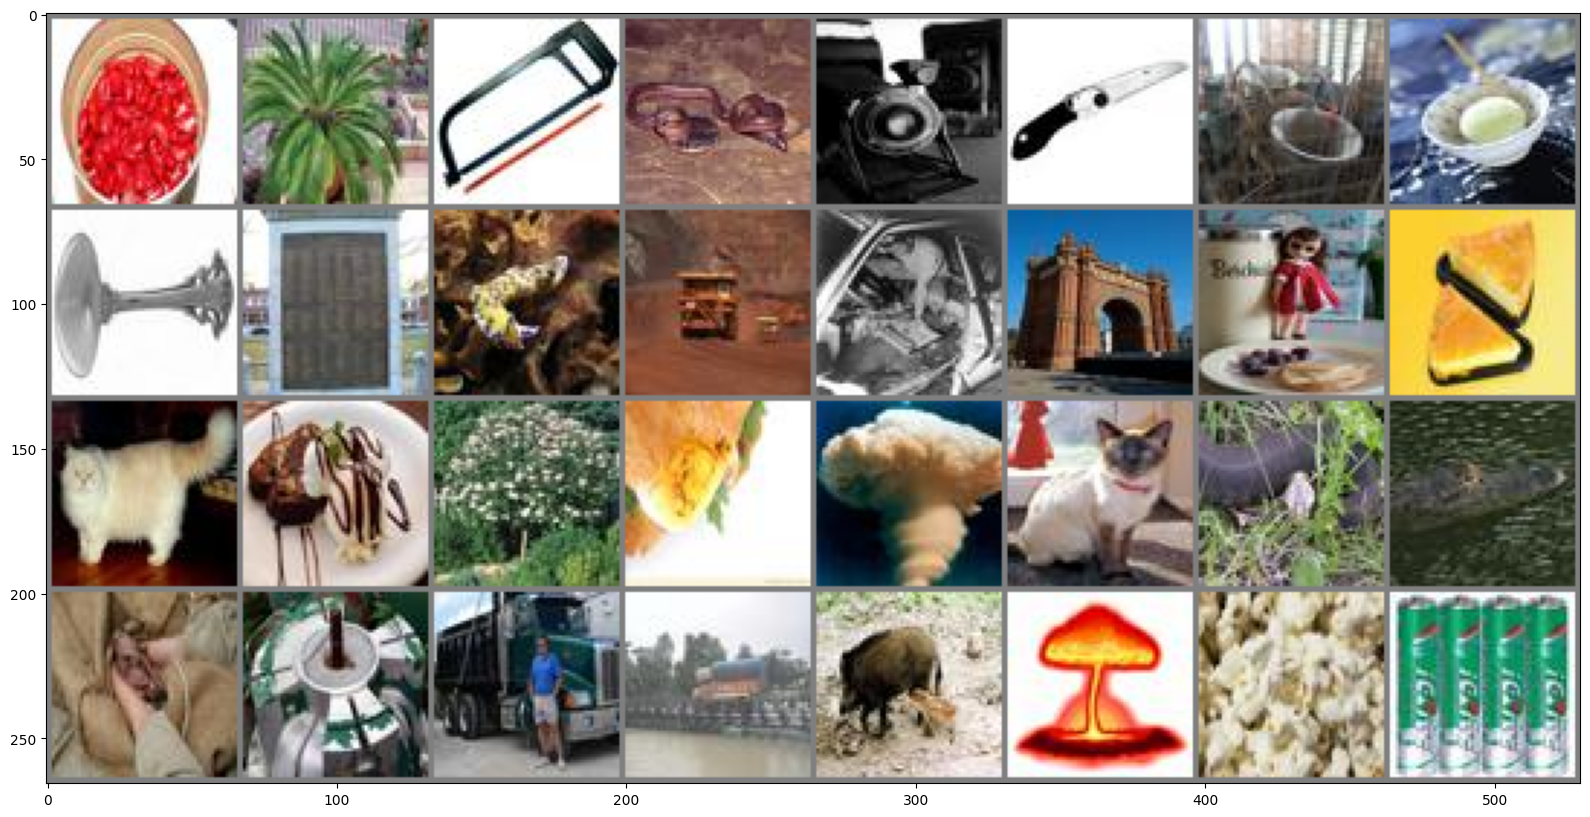

bean palm saw snake camera saw acoustic icecream spoon memorial worm truck bomb memorial bread bread cat icecream birch egg bomb cat snake crocodilian kangaroo motor truck bridge swine bomb corn battery


In [30]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))

# get some random training images
images, labels = next(iter(train_loader))


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(" ".join(f"{idx_to_class[labels[j]]}" for j in range(batch_size)))

In [31]:
class CNN(nn.Module):
    def __init__(self, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(192, 128, kernel_size=3, padding=1)  # Changed from conv3 to conv4
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(128 * 6 * 6, 4096)  # Adjusted input size based on the output size of conv4
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [32]:
model = CNN(len(dataset.classes)).to(device)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.0001)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
mca = MulticlassAccuracy(num_classes=50, average=None).to(device)
EPOCHS_NUMBER = 100
(
    train_losses,
    train_accuracies,
    val_losses,
    val_accuracies,
    train_f1_scores,
    val_f1_scores,
) = ([], [], [], [], [], [])
tqdm_progress = tqdm(range(EPOCHS_NUMBER))

t_batch_num, v_batch_num = len(train_loader), len(val_loader)

for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    train_batch_f1_score_sum, val_batch_f1_score_sum = 0, 0

    model.train()
    for data_patch, label in train_loader:
        data_patch, label = data_patch.to(device), label.to(device)
        optimizer.zero_grad()
        model_output = model(data_patch).squeeze()
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()

    train_batch_loss_avg = train_batch_loss_sum / t_batch_num
    train_batch_accuracy_avg = train_batch_accuracy_sum / t_batch_num

    train_losses.append(train_batch_loss_avg)
    train_accuracies.append(train_batch_accuracy_avg)

    model.eval()
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_predicts = model(val_inputs).squeeze(dim=1)
        val_loss = criterion(val_predicts, val_labels)
        val_batch_loss_sum += val_loss.item()
        val_batch_accuracy_sum += mca(torch.argmax(val_predicts, dim=1), val_labels)

    val_batch_loss_avg = val_batch_loss_sum / v_batch_num
    val_batch_accuracy_avg = val_batch_accuracy_sum / v_batch_num

    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(val_batch_loss_avg)

    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {train_batch_loss_avg},
            "Loss in eval": {val_batch_loss_avg},
        }
    )


 46%|████▌     | 46/100 [16:17<19:07, 21.25s/it, Epoch=46, Los in train={0.1568077346405225}, Loss in eval={5.465462297336376}]  


KeyboardInterrupt: 

In [76]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
labels_train, labels_val = torch.tensor([], device=device), torch.tensor([], device=device)
predicted_train, predicted_val = torch.tensor([], device=device), torch.tensor([], device=device)
model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicts_train = model(inputs)
        predicted_argmax_train = torch.argmax(predicts_train, dim=1)
        labels_train = torch.cat((labels_train, labels))
        predicted_train = torch.cat((predicted_train, predicted_argmax_train))

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicts_val = model(inputs)
        predicted_argmax_val = torch.argmax(predicts_val, dim=1)
        labels_val = torch.cat((labels_val, labels))
        predicted_val = torch.cat((predicted_val, predicted_argmax_val))


tensor([39, 46,  3, 23, 20,  2, 45, 39, 18,  8, 34, 45,  2, 15, 23, 20, 27, 17,
         7, 33, 14, 38,  2, 12, 38, 21, 35, 44,  7, 33, 22, 24, 26, 37, 10, 35,
        16, 46, 35, 16, 24, 23, 32, 22,  5, 43, 32, 43, 46, 42, 35, 45, 37, 23,
        23, 47, 46,  5,  0, 45, 32, 42, 25, 19])
tensor([48, 36, 16, 11, 41, 44, 34,  4, 17, 49, 15,  2, 42, 27, 40, 19, 21, 30,
        46, 49, 14,  3, 17, 36,  8, 35, 40,  4, 43, 41, 27, 25, 23, 38, 31, 14,
        18, 20,  6,  1, 20, 15, 23, 12, 35, 47, 41, 12,  7, 40, 16, 16,  7,  1,
        34, 39, 45,  1, 45,  9, 19, 37,  5, 32])
tensor([20, 46,  3,  5, 14, 33, 42, 49,  2,  9, 35, 33, 19, 33,  2,  0, 37, 32,
        39, 29, 44, 32, 45, 31,  4, 33, 41, 23,  4, 41, 44,  2, 30, 15, 49, 22,
        25, 38, 20, 49, 48, 39, 29, 37,  5, 14, 36, 41, 10,  1, 37, 14, 30, 38,
        46, 39, 26, 29,  3, 49, 29,  2, 43, 38])
tensor([ 2, 24, 38, 36, 49,  7, 23, 23, 15, 48, 32,  8,  1, 49,  3, 35, 18, 15,
        30,  8,  7, 45, 39, 15, 39, 24, 42, 23, 34, 4

In [85]:
labels_train, predicted_train = labels_train.cpu() , predicted_train.cpu()

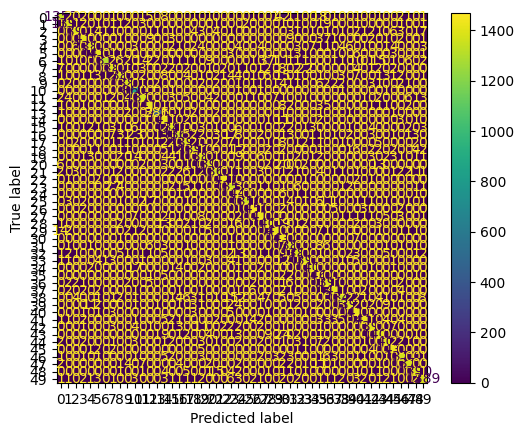

In [86]:
confusion_matrix_train = confusion_matrix(labels_train , predicted_train)
ConfusionMatrixDisplay(confusion_matrix_train).plot()
plt.show()

In [88]:
f1_score(labels_train, predicted_train, average='micro')

0.9690522518428042

In [92]:
mca_eval = MulticlassAccuracy(num_classes=50, average=None)

In [93]:
mca_eval(predicted_train, labels_train)

tensor([0.9363, 0.9789, 0.9640, 0.9731, 0.9604, 0.9847, 0.9078, 0.9546, 0.9472,
        0.9733, 0.9942, 0.9643, 0.9812, 0.9626, 0.9854, 0.9672, 0.9349, 0.9687,
        0.9654, 0.9571, 0.9654, 0.9606, 0.9944, 0.9589, 0.9931, 0.9596, 0.9891,
        0.9766, 0.9617, 0.9726, 0.9938, 0.9740, 0.9598, 0.9720, 0.9784, 0.9919,
        0.9824, 0.9792, 0.9361, 0.9661, 0.9895, 0.9686, 0.9715, 0.9603, 0.9729,
        0.9889, 0.9731, 0.9718, 0.9713, 0.9632])